# Deep Galerkin Method (DGM)

## ODE

We consider:

$\frac{dy}{dx} = y, \quad y(0)=1$

With exact solution:

$y(x)=e^x$

Epoch 0, Loss: 1.337365
Epoch 500, Loss: 0.056605
Epoch 1000, Loss: 0.006582
Epoch 1500, Loss: 0.000901
Epoch 2000, Loss: 0.000411
Epoch 2500, Loss: 0.000185
Epoch 3000, Loss: 0.000087
Epoch 3500, Loss: 0.000048
Epoch 4000, Loss: 0.000030
Epoch 4500, Loss: 0.000030
MAE = 0.0012922370806336403


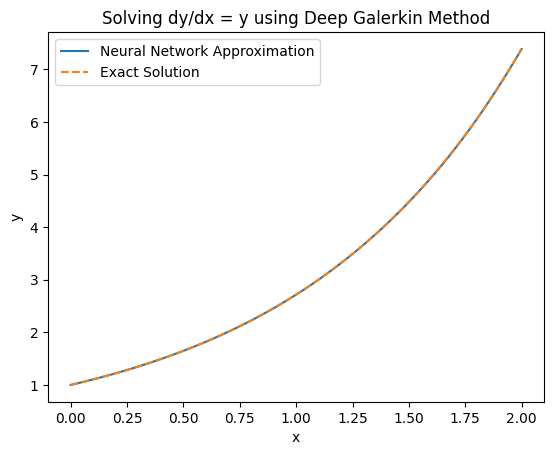

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)

class GalerkinNet(nn.Module):
    def __init__(self):
        super(GalerkinNet, self).__init__()
        self.hidden = nn.Linear(1, 10)
        self.output = nn.Linear(10, 1)
        self.activation = torch.tanh

    def forward(self, x):
        x = self.activation(self.hidden(x))
        return self.output(x)

def test_function(x):
    return torch.exp(-x)

def galerkin_loss_function(model, x_collocation, x_initial):
    x_collocation.requires_grad = True

    y_pred = model(x_collocation)

    dy_dx = torch.autograd.grad(y_pred, x_collocation,
                                torch.ones_like(y_pred), create_graph=True)[0]

    residual = dy_dx - y_pred

    weight = test_function(x_collocation)
    pde_loss = torch.mean((residual * weight) ** 2)

    y_initial_pred = model(x_initial)
    initial_loss = (y_initial_pred - 1) ** 2

    loss = pde_loss + initial_loss
    return loss

x_collocation = torch.linspace(0, 2, 50).reshape(-1, 1)
x_initial = torch.tensor([[0.0]])

model = GalerkinNet()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = galerkin_loss_function(model, x_collocation, x_initial)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.6f}')

x_test = torch.linspace(0, 2, 100).reshape(-1, 1)
y_pred = model(x_test).detach().numpy()
y_true = np.exp(x_test.numpy())

print(f"MAE = {np.mean(np.abs(y_pred - y_true))}")
plt.plot(x_test.numpy(), y_pred, label="Neural Network Approximation")
plt.plot(x_test.numpy(), y_true, label="Exact Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Solving dy/dx = y using Deep Galerkin Method")
plt.show()


## PDE

### Heat equation

$\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}, \quad x \in [0, L], \quad t > 0.$

Initial and boundary conditions:
- Initial: \( $u(x, 0) = f(x)$ \).
- Dirichlet boundary conditions: \( $u(0, t) = u(L, t) = 0$ \).

With considaration $f(x) = \sin(\pi x), L=1, $

The exact solution is:

$u(x,t) = e^{-\alpha \pi^2 t} \sin(\pi x).$

Epoch 0, Loss: 0.226952
Epoch 500, Loss: 0.000420
Epoch 1000, Loss: 0.000222
Epoch 1500, Loss: 0.000173
Epoch 2000, Loss: 0.000148
Epoch 2500, Loss: 0.000124
Epoch 3000, Loss: 0.000109
Epoch 3500, Loss: 0.000095
Epoch 4000, Loss: 0.000083
Epoch 4500, Loss: 0.000073
MAE = 0.005149098661799496


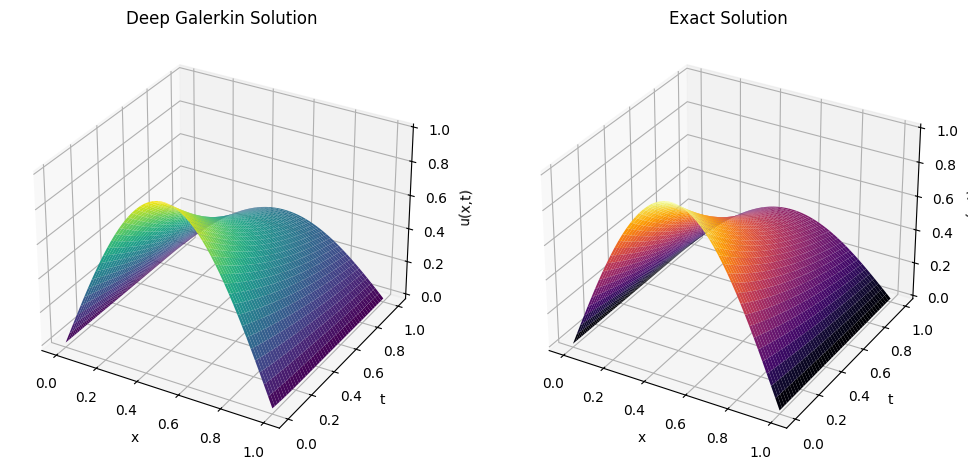

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)

alpha = 0.1

class GalerkinHeatEquationNN(nn.Module):
    def __init__(self):
        super(GalerkinHeatEquationNN, self).__init__()
        self.hidden = nn.Linear(2, 20)
        self.output = nn.Linear(20, 1)
        self.activation = torch.tanh

    def forward(self, x, t):
        inputs = torch.cat((x, t), dim=1)
        hidden_output = self.activation(self.hidden(inputs))
        return self.output(hidden_output)

def exact_solution(x, t):
    return np.exp(-alpha * np.pi**2 * t) * np.sin(np.pi * x)

def test_function(x, t):
    return torch.exp(-x) * torch.exp(-t)

def galerkin_loss_function(model, x_collocation, t_collocation, x_boundary, t_boundary, x_initial, t_initial):
    x_collocation.requires_grad = True
    t_collocation.requires_grad = True

    u_pred = model(x_collocation, t_collocation)

    du_dt = torch.autograd.grad(u_pred, t_collocation,
                                torch.ones_like(u_pred), create_graph=True)[0]
    du_dx = torch.autograd.grad(u_pred, x_collocation,
                                torch.ones_like(u_pred), create_graph=True)[0]
    d2u_dx2 = torch.autograd.grad(du_dx, x_collocation,
                                  torch.ones_like(du_dx), create_graph=True)[0]

    residual = du_dt - alpha * d2u_dx2

    weight = test_function(x_collocation, t_collocation)
    pde_loss = torch.mean((residual * weight) ** 2)

    u_boundary_pred = model(x_boundary, t_boundary)
    boundary_loss = torch.mean(u_boundary_pred ** 2)

    u_initial_pred = model(x_initial, t_initial)
    initial_loss = torch.mean((u_initial_pred - torch.sin(np.pi * x_initial)) ** 2)

    loss = pde_loss + boundary_loss + initial_loss
    return loss

num_collocation = 1000
x_collocation = torch.rand(num_collocation, 1)
t_collocation = torch.rand(num_collocation, 1)

x_boundary = torch.cat([torch.zeros(num_collocation // 2, 1), torch.ones(num_collocation // 2, 1)])
t_boundary = torch.rand(num_collocation, 1)
x_initial = torch.rand(num_collocation, 1)
t_initial = torch.zeros(num_collocation, 1)

model = GalerkinHeatEquationNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = galerkin_loss_function(model, x_collocation, t_collocation, x_boundary, t_boundary, x_initial, t_initial)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.6f}')

X, T = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
X_flat = torch.tensor(X.flatten()).reshape(-1, 1).float()
T_flat = torch.tensor(T.flatten()).reshape(-1, 1).float()

U_pred = model(X_flat, T_flat).detach().numpy().reshape(50, 50)
U_exact = exact_solution(X, T)

print(f"MAE = {np.mean(np.abs(U_pred - U_exact))}")

fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, T, U_pred, cmap="viridis")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u(x,t)")
ax.set_title("Deep Galerkin Solution")

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, T, U_exact, cmap="inferno")
ax2.set_xlabel("x")
ax2.set_ylabel("t")
ax2.set_zlabel("u(x,t)")
ax2.set_title("Exact Solution")

plt.show()
